In [1]:
import pandas as pd
import json
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise
import nltk
from nltk.tokenize import word_tokenize
import os
import spacy
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from itertools import permutations
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy import spatial
import random
import torch
from transformers import BertTokenizer, BertModel
import logging
import matplotlib.pyplot as plt

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load('en_core_web_sm')

In [2]:
original = pd.read_csv('~/Downloads/wikihowSep.csv')
original.head()

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [3]:
# drop rows where at least 1 element is missing
df = original.dropna()
#use only subset of data
test = df[20000:30000]
valid = df[40000:50000]
#df = df[6000:7000]
df = df[:10000]

In [4]:
#remove singleton titles
#for title in df['title']:
    #if (df.title == title).sum() <= 1:
        #df = df[df.title != title]
#print(df['title'].value_counts())

KeyboardInterrupt: 

In [4]:
#remove extra spaces, newlines, and incorrect ending punctuation
def cleanText(string) -> str:
    lyst = string.split()
    return " ".join(lyst).strip(";")

In [5]:
from tqdm import tqdm
def process_instructions(dataframe) -> dict:
    # dictionary of title (article) to text (list of steps)
    wikihow = dict()

    for idx, row in tqdm(df.iterrows()):
        title = row['title']
        text = cleanText(row['headline']) + " " + cleanText(row['text'])
        if title and text:
            if title in wikihow:
                wikihow[title].append(text)
            else:
                wikihow[title] = [text]
    
    return wikihow

In [6]:
# pairs of (instruction, rank)
def get_instruction_rank(database: dict) -> list:
    instruction_rank = list()
    
    for article, instructions in tqdm(database.items()):
        for idx, step in enumerate(instructions, start=1):
            instruction_rank.append((step, idx / len(instructions)))
    
    return instruction_rank

In [7]:
wikihow = process_instructions(dataframe=df)
processed_test = process_instructions(dataframe=df)

10000it [00:01, 5821.45it/s]
10000it [00:01, 6406.02it/s]


In [8]:
def addRank(lyst):
    ranked = list()
    for index, element in enumerate(lyst):
        ranked.append((element, index))
    return ranked

In [9]:
def inOrder(lyst):
    ordered = list()
    for element in lyst:
        element = list(element)
        element.append(element[0][1] < element[1][1])
        ordered.append(tuple(element))
    return ordered

In [10]:
def makePairs(lyst):
    perms = list(permutations(addRank(lyst), 2))
    return inOrder(perms)

In [16]:
def makePairsList(wiki):
    pairslist = list()
    for k in wiki.keys():
        try:
            pairslist += makePairs(wikihow[k])
        except KeyError:
            print("invalid key...")
    return pairslist
pairs = makePairsList(wikihow)

In [12]:
Bertmodel = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
Bertmodel.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [13]:

def embedSentence(text):
    processed_text = " ".join(str(x) for x in gensim.utils.simple_preprocess(text))
    marked_text = "[CLS] " + processed_text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
            outputs = Bertmodel(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    token_vecs_cat = []
    for token in token_embeddings:
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        token_vecs_cat.append(cat_vec)
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    result = list(map(float, list(sentence_embedding)))
    return result

In [25]:
##count = 0
#for text in tqdm(df['text']):
##    try:
##        text = embedSentence(text)
##    except(RuntimeError):
  ##      text = embedSentence(text.split('.')[0])
##        count += 1
##print("Errors: ",count)


  0%|                                                                         | 147/1383743 [00:37<93:07:29,  4.13it/s]


  0%|                                                                         | 308/1383743 [01:11<54:05:56,  7.10it/s]


  0%|                                                                         | 464/1383743 [01:43<73:37:05,  5.22it/s]


  0%|                                                                         | 611/1383743 [02:12<53:50:28,  7.14it/s]


  0%|                                                                         | 748/1383743 [02:40<66:12:39,  5.80it/s]


  0%|                                                                        | 894/1383743 [03:14<121:37:55,  3.16it/s]


  0%|                                                                        | 1037/1383743 [03:49<54:10:48,  7.09it/s]


  0%|                                                                        | 1188/1383743 [04:20<72:37:58,  5.29it/s]


  0%|                                                                        | 1351/1383743 [04:47<62:15:09,  6.17it/s]


  0%|                                                                        | 1490/1383743 [05:18<79:30:10,  4.83it/s]


  0%|                                                                        | 1635/1383743 [05:47<84:17:02,  4.56it/s]


  0%|                                                                       | 1777/1383743 [06:19<143:20:11,  2.68it/s]


  0%|                                                                        | 1926/1383743 [06:50<58:51:10,  6.52it/s]


  0%|                                                                        | 2074/1383743 [07:23<76:03:21,  5.05it/s]


  0%|                                                                        | 2224/1383743 [07:49<44:48:21,  8.56it/s]


  0%|                                                                        | 2371/1383743 [08:18<99:05:52,  3.87it/s]


  0%|▏                                                                       | 2507/1383743 [08:50<70:02:19,  5.48it/s]


  0%|▏                                                                       | 2657/1383743 [09:21<66:35:41,  5.76it/s]


  0%|▏                                                                       | 2806/1383743 [09:51<87:05:24,  4.40it/s]


  0%|▏                                                                       | 2946/1383743 [10:22<84:42:49,  4.53it/s]


  0%|▏                                                                      | 3088/1383743 [10:52<119:43:15,  3.20it/s]


  0%|▏                                                                       | 3231/1383743 [11:22<62:42:36,  6.12it/s]


  0%|▏                                                                       | 3384/1383743 [11:51<50:44:58,  7.56it/s]


  0%|▏                                                                      | 3532/1383743 [12:23<108:03:17,  3.55it/s]


  0%|▏                                                                      | 3682/1383743 [13:03<129:25:50,  2.96it/s]


  0%|▏                                                                       | 3827/1383743 [13:40<84:09:44,  4.55it/s]


  0%|▏                                                                       | 3980/1383743 [14:08<60:31:25,  6.33it/s]


  0%|▏                                                                       | 4158/1383743 [14:36<70:53:55,  5.41it/s]


  0%|▏                                                                       | 4320/1383743 [15:07<91:11:33,  4.20it/s]


  0%|▏                                                                       | 4461/1383743 [15:41<87:17:20,  4.39it/s]


  0%|▏                                                                       | 4610/1383743 [16:09<82:15:29,  4.66it/s]


  0%|▏                                                                      | 4746/1383743 [41:57<123:05:23,  3.11it/s]


  0%|▎                                                                      | 4885/1383743 [42:28<160:20:30,  2.39it/s]


  0%|▎                                                                       | 5035/1383743 [42:58<80:13:22,  4.77it/s]


  0%|▎                                                                       | 5160/1383743 [43:31<85:49:26,  4.46it/s]

KeyboardInterrupt: 

In [14]:
# convert text instructions to a vector with spacy
from tqdm import tqdm
def convert_vector(instruction_rank: list, num_examples: int) -> list:
    vector_rank = list()
    
    for step in tqdm(instruction_rank[:num_examples]):
        instruction1, rank1,instruction2,rank2,tf = step[0][0], step[0][1],step[1][0],step[1][1],step[2]
        doc1 = embedSentence(" ".join(str(x) for x in gensim.utils.simple_preprocess(instruction1)))
        doc2 = embedSentence(" ".join(str(x) for x in gensim.utils.simple_preprocess(instruction2)))
        vector_rank.append((doc1,doc2,tf))
    
    return vector_rank

In [15]:
# reads and preprocesses text (tokenize text into words, remove punctuation, lowercase, etc) for gensim doc2vec model
# lyst is list of each paragraph/step per article (like sample)
# corpus = collection of documents (in this case collection of instruction paragraphs)
def read_corpus(lyst, tokens_only=False):
    for i, line in enumerate(lyst):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(df['text']))

In [17]:
random.shuffle(pairs)
vector_rank = convert_vector(pairs,num_examples = 10000)
test_data = process_instructions(dataframe = test)
test_pairs = makePairsList(test_data)
random.shuffle(test_pairs)
test_vectors = convert_vector(test_pairs,num_examples = 10000)
valid_data = process_instructions(dataframe = valid)
valid_pairs = makePairsList(valid_data)
random.shuffle(valid_pairs)
valid_vectors = convert_vector(valid_pairs,num_examples = 10000)

 45%|██████████████████████████████████▍                                          | 4467/10000 [34:31<40:18,  2.29it/s]

RuntimeError: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1

In [85]:
#vector_rank = convert_vector(pairs, num_examples=1000)



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                 | 1/1000 [00:00<06:30,  2.56it/s]

  0%|▏                                                                                | 2/1000 [00:00<06:40,  2.49it/s]

  0%|▏                                                                                | 3/1000 [00:01<06:29,  2.56it/s]

  0%|▎                                                                                | 4/1000 [00:01<06:29,  2.56it/s]

  0%|▍                                                                                | 5/1000 [00:01<06:36,  2.51it/s]

  1%|▍                                                                                | 6/1000 [00:02<06:16,  2.64it/s]

  1%|▌                                                                                | 7/1000 [00:02<06:30,  2.54it/s]

  1%|▋                        

 13%|██████████▌                                                                    | 134/1000 [00:30<03:58,  3.63it/s]

 14%|██████████▋                                                                    | 135/1000 [00:31<04:12,  3.43it/s]

 14%|██████████▋                                                                    | 136/1000 [00:31<03:59,  3.61it/s]

 14%|██████████▊                                                                    | 137/1000 [00:31<03:45,  3.83it/s]

 14%|██████████▉                                                                    | 138/1000 [00:31<03:28,  4.13it/s]

 14%|██████████▉                                                                    | 139/1000 [00:32<03:58,  3.62it/s]

 14%|███████████                                                                    | 140/1000 [00:32<04:29,  3.19it/s]

 14%|███████████▏                                                                   | 141/1000 [00:32<04:26,  3.22it/s]

 14%|███████████▏               

 27%|█████████████████████▏                                                         | 268/1000 [01:20<05:44,  2.12it/s]

 27%|█████████████████████▎                                                         | 269/1000 [01:20<05:31,  2.20it/s]

 27%|█████████████████████▎                                                         | 270/1000 [01:21<05:24,  2.25it/s]

 27%|█████████████████████▍                                                         | 271/1000 [01:21<05:27,  2.23it/s]

 27%|█████████████████████▍                                                         | 272/1000 [01:22<05:31,  2.19it/s]

 27%|█████████████████████▌                                                         | 273/1000 [01:22<05:28,  2.21it/s]

 27%|█████████████████████▋                                                         | 274/1000 [01:22<05:19,  2.27it/s]

 28%|█████████████████████▋                                                         | 275/1000 [01:23<05:28,  2.20it/s]

 28%|█████████████████████▊     

 40%|███████████████████████████████▊                                               | 402/1000 [02:25<05:18,  1.88it/s]

 40%|███████████████████████████████▊                                               | 403/1000 [02:26<05:11,  1.92it/s]

 40%|███████████████████████████████▉                                               | 404/1000 [02:26<05:21,  1.86it/s]

 40%|███████████████████████████████▉                                               | 405/1000 [02:27<05:32,  1.79it/s]

 41%|████████████████████████████████                                               | 406/1000 [02:28<05:48,  1.71it/s]

 41%|████████████████████████████████▏                                              | 407/1000 [02:28<06:04,  1.63it/s]

 41%|████████████████████████████████▏                                              | 408/1000 [02:29<06:11,  1.60it/s]

 41%|████████████████████████████████▎                                              | 409/1000 [02:30<06:06,  1.61it/s]

 41%|███████████████████████████

 54%|██████████████████████████████████████████▎                                    | 536/1000 [03:26<03:30,  2.21it/s]

 54%|██████████████████████████████████████████▍                                    | 537/1000 [03:26<03:18,  2.33it/s]

 54%|██████████████████████████████████████████▌                                    | 538/1000 [03:26<03:14,  2.37it/s]

 54%|██████████████████████████████████████████▌                                    | 539/1000 [03:27<03:13,  2.38it/s]

 54%|██████████████████████████████████████████▋                                    | 540/1000 [03:27<03:05,  2.48it/s]

 54%|██████████████████████████████████████████▋                                    | 541/1000 [03:28<03:07,  2.45it/s]

 54%|██████████████████████████████████████████▊                                    | 542/1000 [03:28<03:23,  2.25it/s]

 54%|██████████████████████████████████████████▉                                    | 543/1000 [03:29<03:16,  2.33it/s]

 54%|███████████████████████████

 67%|████████████████████████████████████████████████████▉                          | 670/1000 [04:26<03:11,  1.72it/s]

 67%|█████████████████████████████████████████████████████                          | 671/1000 [04:27<03:05,  1.77it/s]

 67%|█████████████████████████████████████████████████████                          | 672/1000 [04:27<03:03,  1.79it/s]

 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [04:28<03:08,  1.74it/s]

 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [04:29<03:08,  1.73it/s]

 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [04:29<02:43,  1.99it/s]

 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [04:29<02:26,  2.21it/s]

 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [04:30<02:16,  2.37it/s]

 68%|███████████████████████████

 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [05:09<01:17,  2.52it/s]

 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [05:09<01:14,  2.63it/s]

 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [05:09<01:10,  2.75it/s]

 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [05:10<01:04,  2.97it/s]

 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [05:10<00:59,  3.24it/s]

 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [05:10<00:54,  3.52it/s]

 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [05:10<00:53,  3.58it/s]

 81%|████████████████████████████████████████████████████████████████               | 811/1000 [05:11<00:58,  3.20it/s]

 81%|███████████████████████████

 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [05:58<00:20,  3.09it/s]

 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [05:59<00:21,  2.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [05:59<00:24,  2.43it/s]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [06:00<00:26,  2.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [06:00<00:27,  2.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [06:01<00:26,  2.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [06:01<00:26,  2.14it/s]

 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [06:02<00:25,  2.19it/s]

 95%|███████████████████████████

In [87]:
def trainTestSplit(p):
    x = list()
    y = list()
    for item in p:
        x.append([item[0],item[1]])
        if(item[2] == True):
            y.append(1)
        else:
            y.append(0)
    return np.array(x),np.array(y)


In [89]:
X_train, y_train = trainTestSplit(vector_rank)
X_test, y_test = trainTestSplit(test_vectors)
X_test.shape
X_valid, y_valid = trainTestSplit(valid_vectors)

In [90]:
from tensorflow import keras
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[2, 768]))
model.add(keras.layers.Dense(300, activation="elu",kernel_initializer="he_normal", use_bias=False))
model.add(keras.layers.Dense(300, activation="elu",kernel_initializer="he_normal", use_bias=False))
model.add(keras.layers.Dense(300,activation="elu",kernel_initializer="he_normal", use_bias=False))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [91]:
model.compile(loss="mse",
              optimizer="sgd",
              metrics=["accuracy"])

In [92]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.59 - ETA: 0s - loss: 0.2472 - accuracy: 0.57 - ETA: 0s - loss: 0.2460 - accuracy: 0.58 - ETA: 0s - loss: 0.2495 - accuracy: 0.57 - ETA: 0s - loss: 0.2486 - accuracy: 0.56 - 1s 28ms/step - loss: 0.2483 - accuracy: 0.5650 - val_loss: 0.2706 - val_accuracy: 0.5300
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.50 - ETA: 0s - loss: 0.2506 - accuracy: 0.54 - ETA: 0s - loss: 0.2493 - accuracy: 0.55 - ETA: 0s - loss: 0.2315 - accuracy: 0.61 - ETA: 0s - loss: 0.2272 - accuracy: 0.63 - ETA: 0s - loss: 0.2273 - accuracy: 0.63 - 0s 15ms/step - loss: 0.2297 - accuracy: 0.6210 - val_loss: 0.2937 - val_accuracy: 0.5000
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.53 - ETA: 0s - loss: 0.2184 - accuracy: 0.67 - ETA: 0s - loss: 0.2180 - accuracy: 0.64 - ETA: 0s - loss: 0.2156 - accuracy: 0.65 - ETA: 0s - loss: 0.2077 - accuracy: 0

32/32 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.78 - ETA: 0s - loss: 0.0975 - accuracy: 0.86 - ETA: 0s - loss: 0.1170 - accuracy: 0.81 - ETA: 0s - loss: 0.1113 - accuracy: 0.83 - ETA: 0s - loss: 0.1130 - accuracy: 0.83 - ETA: 0s - loss: 0.1107 - accuracy: 0.83 - 0s 13ms/step - loss: 0.1107 - accuracy: 0.8370 - val_loss: 0.3056 - val_accuracy: 0.5720
Epoch 42/50
32/32 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.65 - ETA: 0s - loss: 0.1387 - accuracy: 0.78 - ETA: 0s - loss: 0.1375 - accuracy: 0.80 - ETA: 0s - loss: 0.1349 - accuracy: 0.79 - ETA: 0s - loss: 0.1216 - accuracy: 0.82 - ETA: 0s - loss: 0.1153 - accuracy: 0.83 - 0s 13ms/step - loss: 0.1159 - accuracy: 0.8320 - val_loss: 0.3242 - val_accuracy: 0.5510
Epoch 43/50
32/32 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.71 - ETA: 0s - loss: 0.1017 - accuracy: 0.86 - ETA: 0s - loss: 0.1155 - accuracy: 0.82 - ETA: 0s - loss: 0.1015 - accuracy: 0.85 - ETA

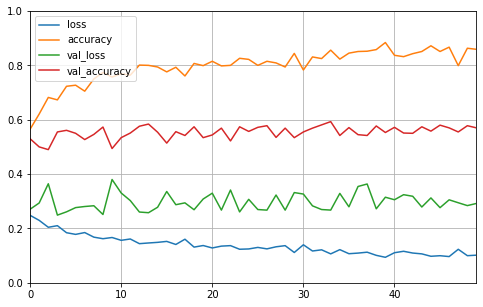

In [93]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()